In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.path import Path
from tqdm import tqdm
import json
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [24]:
# Color codes for damage types
DAMAGE_COLORS = {
    "no-damage": (0, 255, 0, 50),
    "minor-damage": (0, 0, 255, 50),
    "major-damage": (255, 69, 0, 50),
    "destroyed": (255, 0, 0, 50),
    "un-classified": (255, 255, 255, 50)
}

# Custom Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_size=(512, 512)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_size = target_size
        
        self.images = sorted(os.listdir(image_dir))
        self.labels = sorted(os.listdir(label_dir))
    
    def __len__(self):
        return len(self.images)
    
    def get_damage_type(self, properties):
        if 'subtype' in properties:
            return properties['subtype']
        return 'no-damage'
    
    def create_mask(self, image_json, width, height):
        """Create a mask image with different colors for damage types"""
        mask = np.zeros((height, width, 4), dtype=np.uint8)
        
        for feature in image_json['features']['xy']:
            damage_type = self.get_damage_type(feature['properties'])
            polygon = wkt.loads(feature['wkt'])
            
            # Create a mask for this polygon
            poly_mask = Image.new('RGBA', (width, height), (0, 0, 0, 0))
            draw = ImageDraw.Draw(poly_mask)
            
            if isinstance(polygon, (Polygon, MultiPolygon)):
                if isinstance(polygon, MultiPolygon):
                    polygons = list(polygon)
                else:
                    polygons = [polygon]
                
                for poly in polygons:
                    coords = list(poly.exterior.coords)
                    draw.polygon(coords, fill=DAMAGE_COLORS[damage_type])
            
            # Convert to numpy and combine
            poly_mask = np.array(poly_mask)
            mask = np.maximum(mask, poly_mask)
        
        return mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        original_size = image.size
        
        # Load and parse label JSON
        with open(label_path, 'r') as f:
            label_data = json.load(f)
        
        # Create mask with damage colors
        mask = self.create_mask(label_data, original_size[0], original_size[1])
        mask = Image.fromarray(mask)
        
        if self.transform:
            image = self.transform(image)
            # Apply same transform to mask but without normalization
            mask_transform = transforms.Compose([
                transforms.Resize(self.target_size),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask)
        
        return image, mask

def show_samples(dataloader):
    """Display a batch of images and their corresponding masks"""
    plt.rcParams['figure.figsize'] = (20, 10)
    images, masks = next(iter(dataloader))
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    for i in range(4):
        # Show image
        img = images[i].permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        axes[0, i].imshow(img.numpy())
        axes[0, i].set_title('Original Image')
        axes[0, i].axis('off')
        
        # Show mask with damage colors
        mask = masks[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(mask)
        axes[1, i].set_title('Building Damage Mask')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader):
    """Visualize model predictions with damage colors"""
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    for i in range(2):
        # Show original image
        img = images[i].cpu().permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        axes[0, i].imshow(img.numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Show ground truth mask
        mask = masks[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(mask)
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')
        
        # Show prediction
        pred_mask = preds[i].cpu().numpy()
        axes[2, i].imshow(pred_mask)
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    for i in range(2):
        # Show original image
        img = images[i].cpu().permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        axes[0, i].imshow(img.numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Show ground truth mask
        mask = masks[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(mask)
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')
        
        # Show prediction
        pred_mask = preds[i].cpu().numpy()
        axes[2, i].imshow(pred_mask)
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
# Data directories
train_img_dir = 'train_images_labels_targets/train/images'
train_label_dir = 'train_images_labels_targets/train/labels'

# Transform for input images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = SegmentationDataset(train_img_dir, train_label_dir, transform=transform)
n_samples = len(full_dataset)
subset_length = n_samples // 10
dataloader = DataLoader(full_dataset, batch_size=4, shuffle=True)

Visualizing sample images and labels...


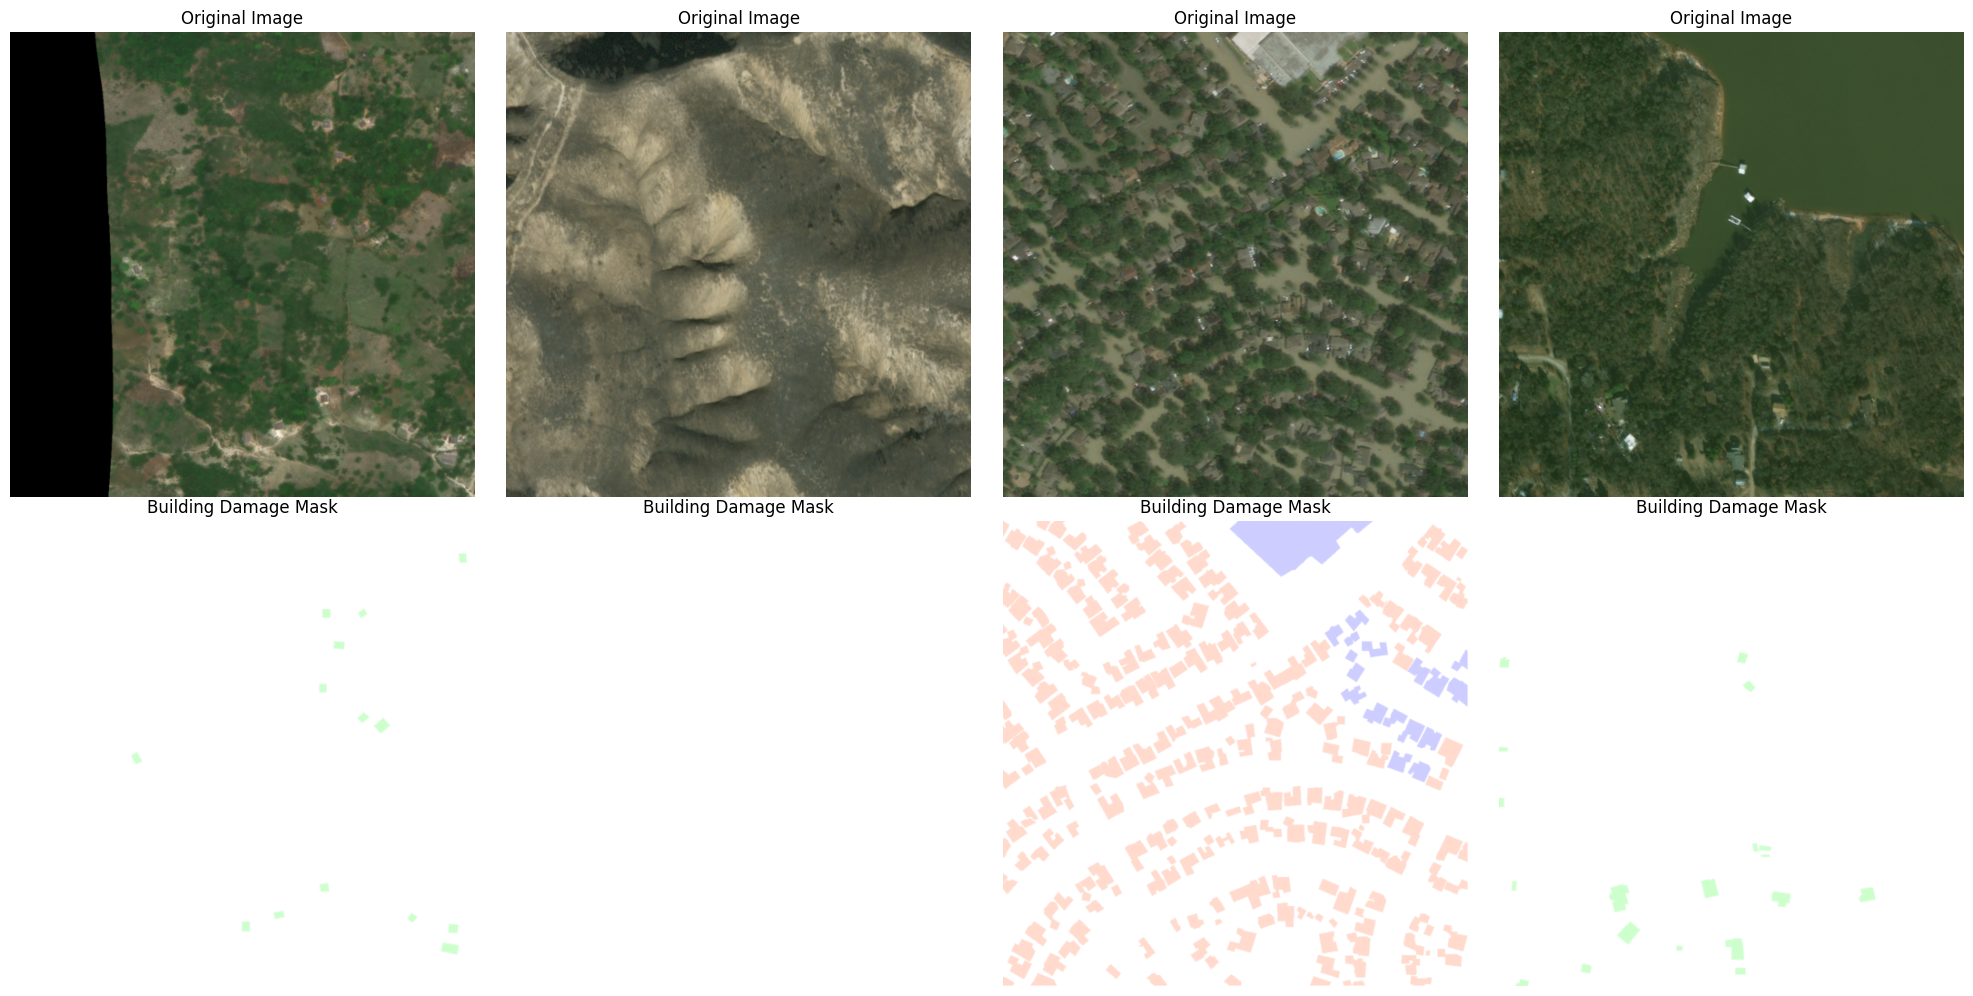

In [5]:
# Visualize samples
print("Visualizing sample images and labels...")
show_samples(dataloader)

In [6]:
# Load model
print("Loading DeepLabV3 model...")
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)

Loading DeepLabV3 model...


Using cache found in C:\Users\dipen/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\dipen\OneDrive\Desktop\Qriocity\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dipen\OneDrive\Desktop\Qriocity\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Modify the classifier for our number of classes (5 damage types)
num_classes = 5  # no-damage, minor-damage, major-damage, destroyed, un-classified
model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

model = model.to(device)

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
print("Starting training...")
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Create indices for complete batches only
    indices = np.random.choice(n_samples, subset_length, replace=False)
    # Ensure we have an even number of samples for batch size 2
    if len(indices) % 2 != 0:
        indices = indices[:-(len(indices) % 2)]
    
    sampler = SubsetRandomSampler(indices)
    dataloader = DataLoader(
        full_dataset, 
        batch_size=2,
        sampler=sampler,
        drop_last=True  # Drop incomplete batches
    )
    
    for images, masks in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks.argmax(dim=1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss:  {avg_loss:.4f}')

Starting training...


Epoch 1/10: 100%|██████████| 279/279 [14:02<00:00,  3.02s/it]


Epoch 1/10, Loss:  0.1408


Epoch 2/10: 100%|██████████| 279/279 [17:56<00:00,  3.86s/it]


Epoch 2/10, Loss:  0.1274


Epoch 3/10: 100%|██████████| 279/279 [14:19<00:00,  3.08s/it]


Epoch 3/10, Loss:  0.1094


Epoch 4/10: 100%|██████████| 279/279 [14:13<00:00,  3.06s/it]


Epoch 4/10, Loss:  0.1044


Epoch 5/10: 100%|██████████| 279/279 [14:33<00:00,  3.13s/it]


Epoch 5/10, Loss:  0.1104


Epoch 6/10: 100%|██████████| 279/279 [13:37<00:00,  2.93s/it]


Epoch 6/10, Loss:  0.0966


Epoch 7/10: 100%|██████████| 279/279 [15:48<00:00,  3.40s/it]


Epoch 7/10, Loss:  0.1309


Epoch 8/10: 100%|██████████| 279/279 [14:49<00:00,  3.19s/it]


Epoch 8/10, Loss:  0.1112


Epoch 9/10: 100%|██████████| 279/279 [14:13<00:00,  3.06s/it]


Epoch 9/10, Loss:  0.0934


Epoch 10/10: 100%|██████████| 279/279 [13:45<00:00,  2.96s/it]

Epoch 10/10, Loss:  0.1054


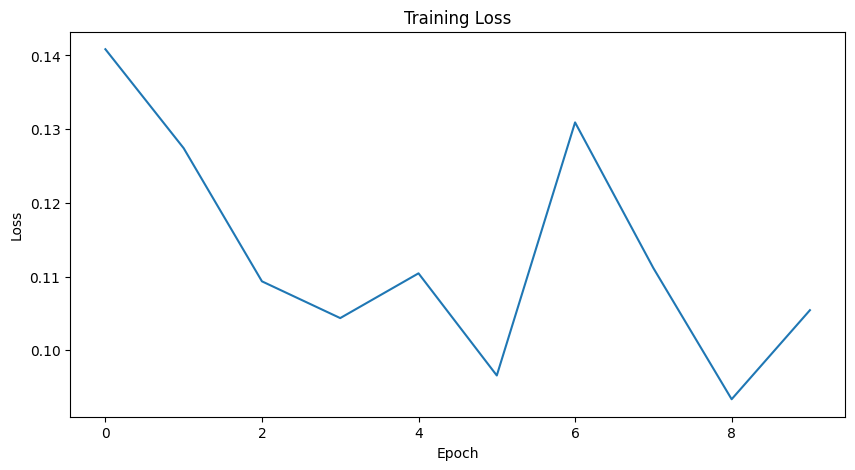

In [26]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [27]:
# Save the model
print("Saving model...")
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses[-1],
}, 'segmentation_model.pth')

print('Model saved successfully!')

Saving model...
Model saved successfully!


Visualizing predictions...


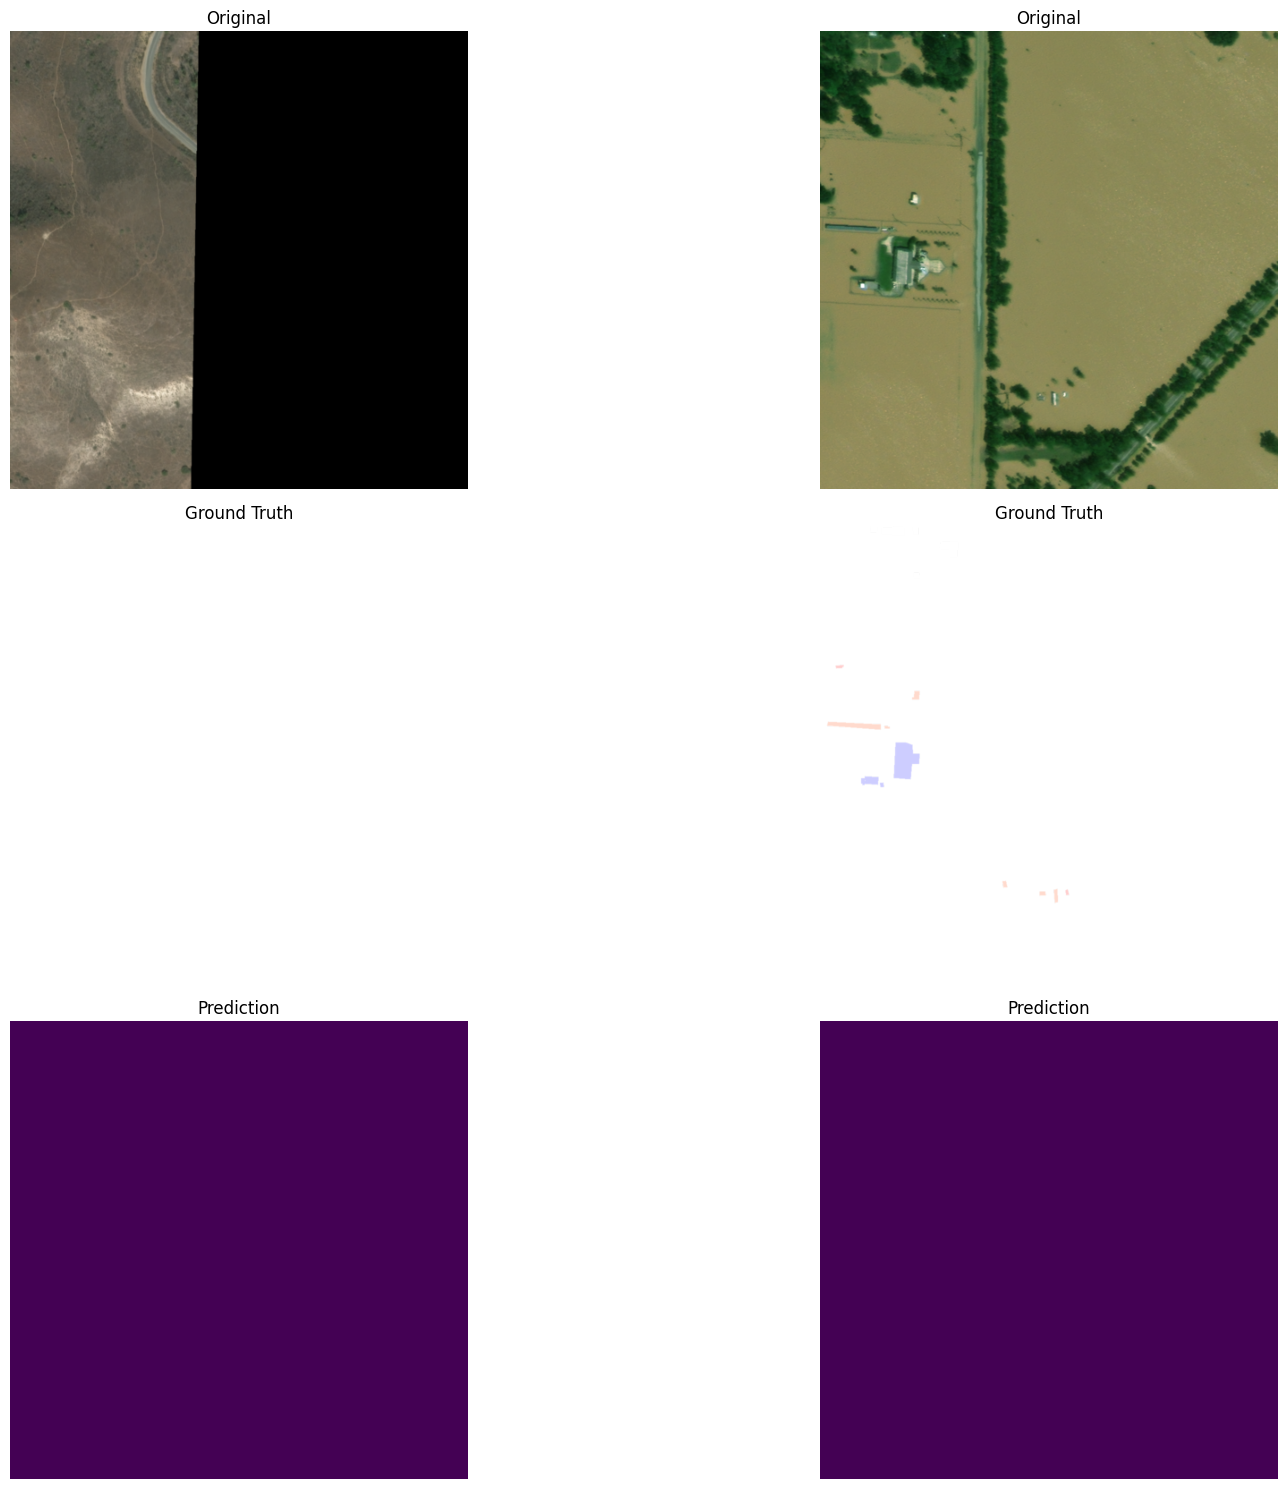

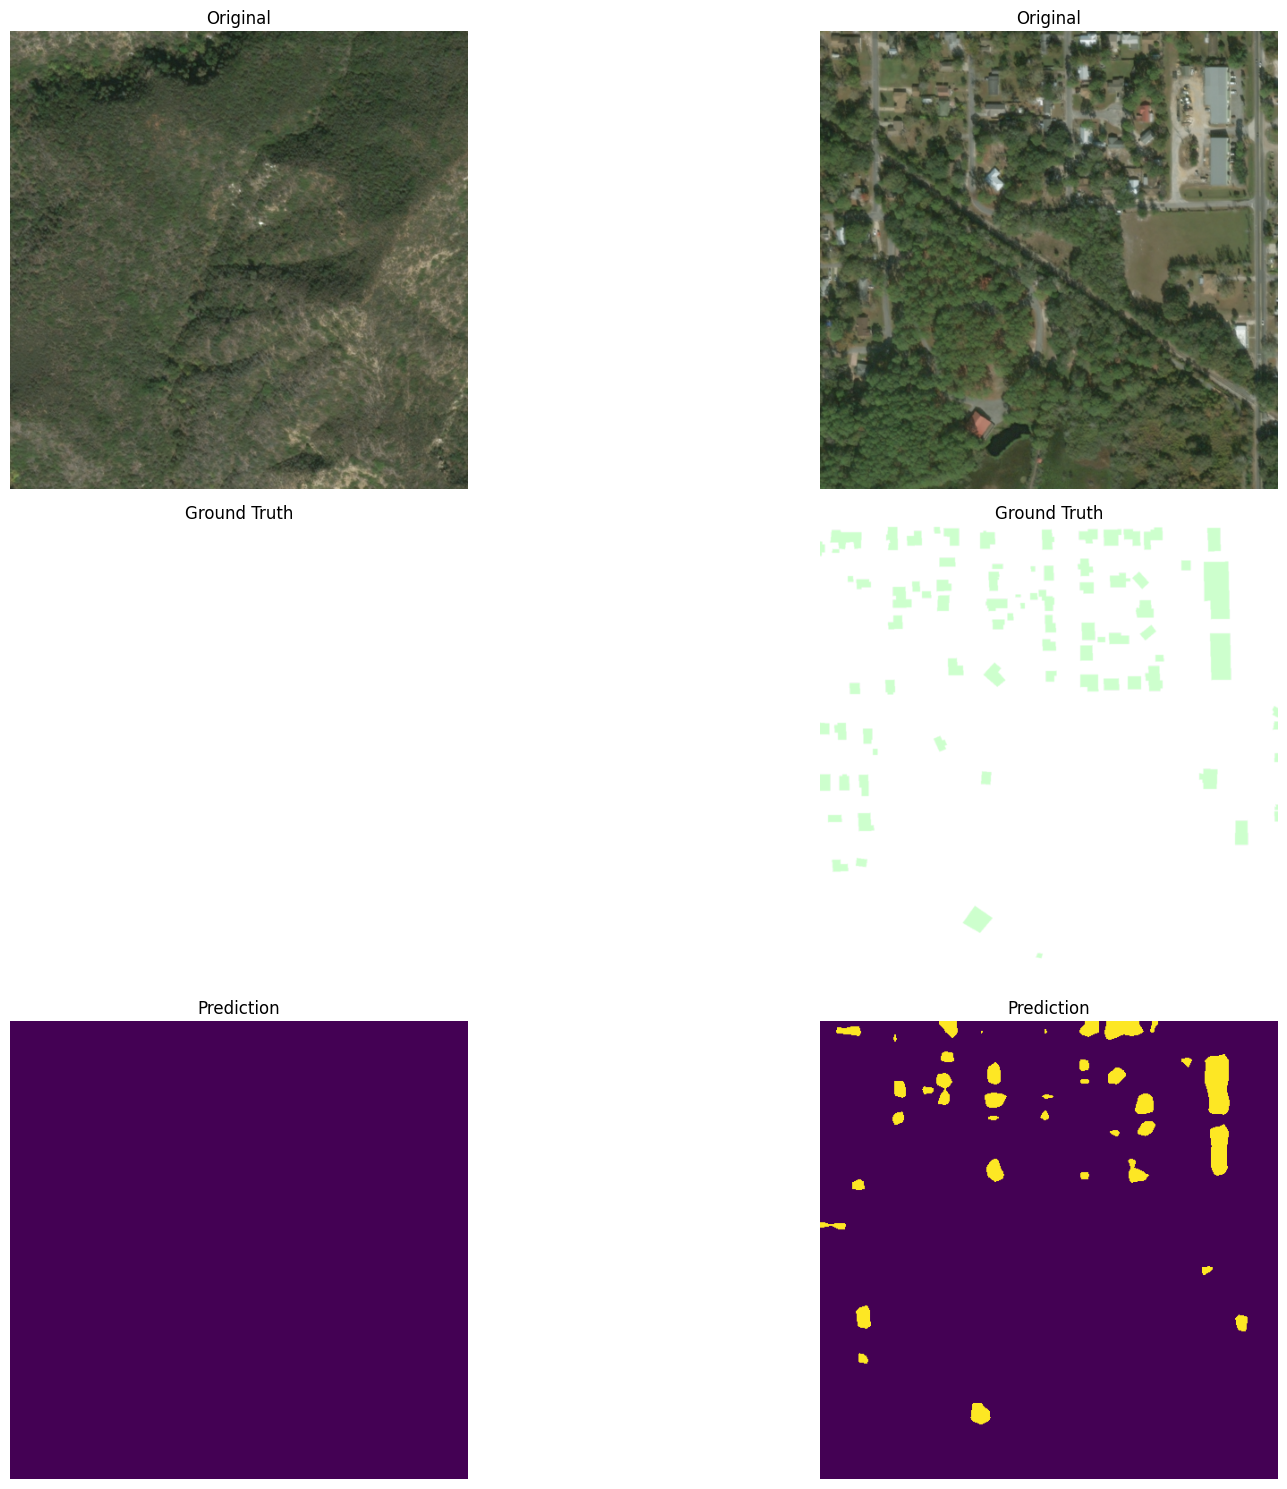

In [25]:
# Visualize predictions
print("Visualizing predictions...")
visualize_predictions(model, dataloader)